# DT Parameter Optimization

Summary: Trained a couple of models on the ANSYS Manual simulations --> able to predict and has the goal of trying to maximize rxn force with moderately high y/z deformation

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


## Configuration / data loading

In [2]:
#File path
EXCEL_FILE = 'ANSYS Data.xlsx' 
SHEET_NAME = 'Sheet2'

# Input feature
INPUT_FEATURES = [
    'Height', 'Waist_D', 'Top_D', 'Bottom_D', 'Wire',
    'CellD_V', 'CellD_H', 'Height_adj', 'V_planespace',
    'Angle_adjustment', 'Mesh Element Size', 'Displacement'
]

# Output
OUTPUT_TARGETS = [
    'Reaction force (N)',
    'y deformation (mm)',
    'z deformation (mm)',
    'Relative Flexibility'
]

print("Configuration set")
print(f"\nInput Features: {len(INPUT_FEATURES)}")
print(f"Output Targets: {len(OUTPUT_TARGETS)}")

Configuration set

Input Features: 12
Output Targets: 4


## Helper functions
(details not too important here)

In [3]:
def load_data_from_excel(file_path, sheet_name='Sheet1'):
    """
    Load stent data from Excel file.
    """
    print("=" * 70)
    print("Loading Data from Excel")
    print("=" * 70)

    df = pd.read_excel(file_path, sheet_name=sheet_name)

    print(f"\nDataset loaded successfully")
    print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")

    # Check for missing values
    missing = df.isnull().sum()
    if missing.any():
        print("\nWarning: Missing values detected:")
        print(missing[missing > 0])
    else:
        print("No missing values detected")

    return df


def prepare_features_and_targets(df):
    """
    Extract and prepare input features (X) and output targets (y).
    Handles z deformation by taking absolute values of min/max.
    """
    print("\n" + "=" * 70)
    print("Preparing Features and Targets")
    print("=" * 70)

    # Extract input features
    X = df[INPUT_FEATURES].values

    # Handle z deformation - check if single column exists or need to compute
    if 'z deformation (mm)' in df.columns:
        y_data = df[OUTPUT_TARGETS].values
    else:
        # Compute z deformation from max/min columns
        y_data = []
        for target in OUTPUT_TARGETS:
            if target == 'z deformation (mm)':
                z_cols = [col for col in df.columns if 'z deformation' in col.lower()]
                if len(z_cols) >= 2:
                    z_values = df[z_cols].abs().max(axis=1).values
                    y_data.append(z_values)
                else:
                    raise ValueError(f"Cannot find z deformation columns")
            else:
                y_data.append(df[target].values)
        y_data = np.column_stack(y_data)

    y = y_data

    print(f"\nInput Features (X): {X.shape}")
    print(f"Output Targets (y): {y.shape}")

    return X, y


def train_multioutput_model(X, y):
    """
    Train a multi-output Random Forest model with Leave-One-Out cross-validation.
    """
    print("\n" + "=" * 70)
    print("Training Multi-Output Prediction Model")
    print("=" * 70)

    # Scale the data
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y)

    print("\nData scaling completed")

    # Create multi-output Random Forest
    base_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=3,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42,
        bootstrap=True
    )

    model = MultiOutputRegressor(base_model)

    print("Model: Multi-Output Random Forest (100 trees, max_depth=3)")

    # Leave-One-Out Cross-Validation
    print(f"\nRunning Leave-One-Out Cross-Validation...")

    loo = LeaveOneOut()
    cv_predictions = np.zeros_like(y_scaled)

    fold = 1
    for train_idx, test_idx in loo.split(X_scaled):
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y_scaled[train_idx], y_scaled[test_idx]

        model_cv = MultiOutputRegressor(RandomForestRegressor(
            n_estimators=100, max_depth=3, min_samples_split=2,
            min_samples_leaf=1, random_state=42, bootstrap=True
        ))

        model_cv.fit(X_train, y_train)
        cv_predictions[test_idx] = model_cv.predict(X_test)

        if fold % 3 == 0 or fold == len(X):
            print(f"  Progress: {fold}/{len(X)} folds completed", end='\r')
        fold += 1

    print(f"\nCross-validation complete")

    # Transform predictions back to original scale
    cv_predictions_original = scaler_y.inverse_transform(cv_predictions)

    # Calculate metrics
    print(f"\n{'Target':<30} {'R²':<10} {'MAE':<12} {'RMSE':<12}")
    print("-" * 70)

    cv_results = {}
    for i, target_name in enumerate(OUTPUT_TARGETS):
        r2 = r2_score(y[:, i], cv_predictions_original[:, i])
        mae = mean_absolute_error(y[:, i], cv_predictions_original[:, i])
        rmse = np.sqrt(mean_squared_error(y[:, i], cv_predictions_original[:, i]))

        cv_results[target_name] = {'r2': r2, 'mae': mae, 'rmse': rmse}

        print(f"{target_name:<30} {r2:>8.4f}  {mae:>10.6f}  {rmse:>10.6f}")

    # Train final model on all data
    print("\nTraining final model on complete dataset...")
    model.fit(X_scaled, y_scaled)
    print("Model training complete")

    return model, scaler_X, scaler_y, cv_results


def plot_predictions(model, X, y, scaler_X, scaler_y):
    """
    Create visualization comparing predicted vs actual values.
    """
    # Make predictions
    X_scaled = scaler_X.transform(X)
    y_pred_scaled = model.predict(X_scaled)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)

    # Create 2x2 subplot
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    axes = axes.ravel()

    for i, target_name in enumerate(OUTPUT_TARGETS):
        ax = axes[i]

        # Scatter plot
        ax.scatter(y[:, i], y_pred[:, i], alpha=0.7, s=100,
                  edgecolors='black', linewidth=1.5, c=f'C{i}')

        # Perfect prediction line
        min_val = min(y[:, i].min(), y_pred[:, i].min())
        max_val = max(y[:, i].max(), y_pred[:, i].max())
        ax.plot([min_val, max_val], [min_val, max_val],
               'r--', lw=2, label='Perfect Prediction')

        # Calculate R²
        r2 = r2_score(y[:, i], y_pred[:, i])

        # Labels and title
        ax.set_xlabel('Actual Value', fontsize=12, fontweight='bold')
        ax.set_ylabel('Predicted Value', fontsize=12, fontweight='bold')
        ax.set_title(f'{target_name}\nR² = {r2:.4f}',
                    fontsize=13, fontweight='bold')
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3, linestyle='--')

    plt.tight_layout()
    plt.savefig('model_performance.png', dpi=300, bbox_inches='tight')
    print("Visualization saved as 'model_performance.png'")
    plt.show()

    return fig


def predict_new_design(model, scaler_X, scaler_y, new_params):
    """
    Predict outputs for new design parameters.

    Args:
        model: Trained model
        scaler_X: Fitted scaler for inputs
        scaler_y: Fitted scaler for outputs
        new_params: Dictionary of parameter values

    Returns:
        predictions: Dictionary of predicted values
    """
    # Convert to array
    X_new = np.array([new_params[feat] for feat in INPUT_FEATURES]).reshape(1, -1)

    # Display input parameters
    print("=" * 70)
    print("INPUT PARAMETERS:")
    print("=" * 70)
    for i, feat in enumerate(INPUT_FEATURES):
        print(f"  {feat:<25} = {X_new[0, i]:.4f}")

    # Scale and predict
    X_new_scaled = scaler_X.transform(X_new)
    y_pred_scaled = model.predict(X_new_scaled)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)

    # Create results dictionary
    predictions = {OUTPUT_TARGETS[i]: y_pred[0, i] for i in range(len(OUTPUT_TARGETS))}

    # Display predictions
    print("\n" + "=" * 70)
    print("PREDICTED OUTPUTS:")
    print("=" * 70)
    for target, value in predictions.items():
        if abs(value) < 0.01:
            print(f"  {target:<30} = {value:.6e}")
        else:
            print(f"  {target:<30} = {value:.6f}")

    # Evaluate design
    print("\n" + "=" * 70)
    print("DESIGN EVALUATION:")
    print("=" * 70)

    reaction_force = predictions['Reaction force (N)']
    y_def = predictions['y deformation (mm)']
    z_def = predictions['z deformation (mm)']

    print(f"  Reaction Force: {reaction_force:.6e}")
    if reaction_force > -1e-6:
        print(f"    Good - High reaction force (less negative)")
    else:
        print(f"    Moderate - Could be improved")

    print(f"\n  Y Deformation: {y_def:.4f} mm")
    if 0.7 < y_def < 0.8:
        print(f"    Excellent - Moderate deformation range")
    elif y_def > 0.65:
        print(f"    Good - Acceptable deformation")
    else:
        print(f"    Low deformation")

    print(f"\n  Z Deformation: {z_def:.4f} mm")
    if 0.5 < z_def < 1.0:
        print(f"    Good - Moderate deformation range")
    elif z_def < 1.5:
        print(f"    Acceptable")
    else:
        print(f"    High deformation - may need review")

    return predictions

## Loading the data into a pandas Dataframe

In [4]:
# Load data
df = load_data_from_excel(EXCEL_FILE, SHEET_NAME)

# Display first few rows
print("\nFirst few rows of data:")
display(df.head())

# Display summary statistics
print("\nSummary Statistics:")
display(df.describe())

Loading Data from Excel

Dataset loaded successfully
Shape: 9 rows × 20 columns

Date    8
Name    8
dtype: int64

First few rows of data:


,Date,Name,"CAD File Name (Lab 3, leave blank if personal)",Height,Waist_D,Top_D,Bottom_D,Wire,CellD_V,CellD_H,Height_adj,V_planespace,Angle_adjustment,Mesh Element Size,Displacement,Analysis Type,Reaction force (N),y deformation (mm),z deformation (mm),Relative Flexibility
0,260105.0,TL,260106 v1,12,20,35,35,0.3,4,16,12.6,3.15,0.43,1,-1,Two-point test,-4.313900e-07,0.79487,0.10268,-0.10580
1,NaN,NaN,260106 v2,12,20,35,35,0.3,6,20,12.6,2.10,0.43,1,-1,Two-point test,-1.104800e-06,0.72062,0.49172,-0.49414
2,NaN,NaN,260106 v3,12,20,35,35,0.3,6,24,12.6,2.10,0.43,1,-1,Two-point test,-1.224200e-06,0.73642,0.56622,-0.56259
3,NaN,NaN,260106 v4,12,20,35,35,0.3,6,32,12.6,2.10,0.43,1,-1,Two-point test,-1.480000e-06,0.75344,0.60230,-0.60595
4,NaN,NaN,260106 v5,12,20,35,35,0.3,6,40,12.6,2.10,0.43,1,-1,Two-point test,-1.446300e-06,0.76240,0.52520,-0.52659



Summary Statistics:


,Date,Height,Waist_D,Top_D,Bottom_D,Wire,CellD_V,CellD_H,Height_adj,V_planespace,Angle_adjustment,Mesh Element Size,Displacement,Reaction force (N),y deformation (mm),z deformation (mm),Relative Flexibility
count,1.0,9.0,9.0,9.0,9.0,9.000000,9.000000,9.000000,9.000000,9.000000,9.000,9.0,9.0,9.000000e+00,9.000000,9.000000,9.000000
mean,260105.0,12.0,20.0,35.0,35.0,0.288889,7.111111,29.777778,12.577778,1.923111,0.414,1.0,-1.0,-1.420547e-06,0.759710,0.690584,-0.689826
std,NaN,0.0,0.0,0.0,0.0,0.033333,2.260777,9.189366,0.066667,0.590154,0.048,0.0,0.0,6.466719e-07,0.023667,0.354071,0.350720
min,260105.0,12.0,20.0,35.0,35.0,0.200000,4.000000,16.000000,12.400000,1.033000,0.286,1.0,-1.0,-2.601500e-06,0.720620,0.102680,-1.362700
25%,260105.0,12.0,20.0,35.0,35.0,0.300000,6.000000,24.000000,12.600000,1.575000,0.430,1.0,-1.0,-1.589600e-06,0.748270,0.525200,-0.877850
50%,260105.0,12.0,20.0,35.0,35.0,0.300000,6.000000,32.000000,12.600000,2.100000,0.430,1.0,-1.0,-1.446300e-06,0.761780,0.602300,-0.605950
75%,260105.0,12.0,20.0,35.0,35.0,0.300000,8.000000,40.000000,12.600000,2.100000,0.430,1.0,-1.0,-1.104800e-06,0.770160,0.887070,-0.526590
max,260105.0,12.0,20.0,35.0,35.0,0.300000,12.000000,40.000000,12.600000,3.150000,0.430,1.0,-1.0,-4.313900e-07,0.794870,1.374400,-0.105800


## Prep data for training

In [5]:
X, y = prepare_features_and_targets(df)

# Create DataFrames for better visualization
X_df = pd.DataFrame(X, columns=INPUT_FEATURES)
y_df = pd.DataFrame(y, columns=OUTPUT_TARGETS)

print("\nInput Features (X):")
display(X_df)

print("\nOutput Targets (y):")
display(y_df)


Preparing Features and Targets

Input Features (X): (9, 12)
Output Targets (y): (9, 4)

Input Features (X):


,Height,Waist_D,Top_D,Bottom_D,Wire,CellD_V,CellD_H,Height_adj,V_planespace,Angle_adjustment,Mesh Element Size,Displacement
0,12.0,20.0,35.0,35.0,0.3,4.0,16.0,12.6,3.150,0.430,1.0,-1.0
1,12.0,20.0,35.0,35.0,0.3,6.0,20.0,12.6,2.100,0.430,1.0,-1.0
2,12.0,20.0,35.0,35.0,0.3,6.0,24.0,12.6,2.100,0.430,1.0,-1.0
3,12.0,20.0,35.0,35.0,0.3,6.0,32.0,12.6,2.100,0.430,1.0,-1.0
4,12.0,20.0,35.0,35.0,0.3,6.0,40.0,12.6,2.100,0.430,1.0,-1.0
5,12.0,20.0,35.0,35.0,0.3,8.0,24.0,12.6,1.575,0.430,1.0,-1.0
6,12.0,20.0,35.0,35.0,0.3,8.0,32.0,12.6,1.575,0.430,1.0,-1.0
7,12.0,20.0,35.0,35.0,0.3,8.0,40.0,12.6,1.575,0.430,1.0,-1.0
8,12.0,20.0,35.0,35.0,0.2,12.0,40.0,12.4,1.033,0.286,1.0,-1.0



Output Targets (y):


,Reaction force (N),y deformation (mm),z deformation (mm),Relative Flexibility
0,-4.313900e-07,0.79487,0.10268,-0.10580
1,-1.104800e-06,0.72062,0.49172,-0.49414
2,-1.224200e-06,0.73642,0.56622,-0.56259
3,-1.480000e-06,0.75344,0.60230,-0.60595
4,-1.446300e-06,0.76240,0.52520,-0.52659
5,-1.589600e-06,0.74827,0.73169,-0.72754
6,-2.085700e-06,0.76178,0.88707,-0.87785
7,-2.601500e-06,0.77016,0.93398,-0.94527
8,-8.214300e-07,0.78943,1.37440,-1.36270


## Performance visualization

In [6]:
model, scaler_X, scaler_y, cv_results = train_multioutput_model(X, y)



Training Multi-Output Prediction Model

Data scaling completed
Model: Multi-Output Random Forest (100 trees, max_depth=3)

Running Leave-One-Out Cross-Validation...
  Progress: 9/9 folds completed
Cross-validation complete

Target                         R²         MAE          RMSE        
----------------------------------------------------------------------
Reaction force (N)              -0.2403    0.000001    0.000001
y deformation (mm)              -0.3501    0.016912    0.025926
z deformation (mm)               0.5186    0.170880    0.231624
Relative Flexibility             0.5164    0.172419    0.229951

Training final model on complete dataset...
Model training complete


## Plotted predictions

(low amount of samples so it isn't perfectly robust, but models did decent overall (R^2 > .75))

Visualization saved as 'model_performance.png'


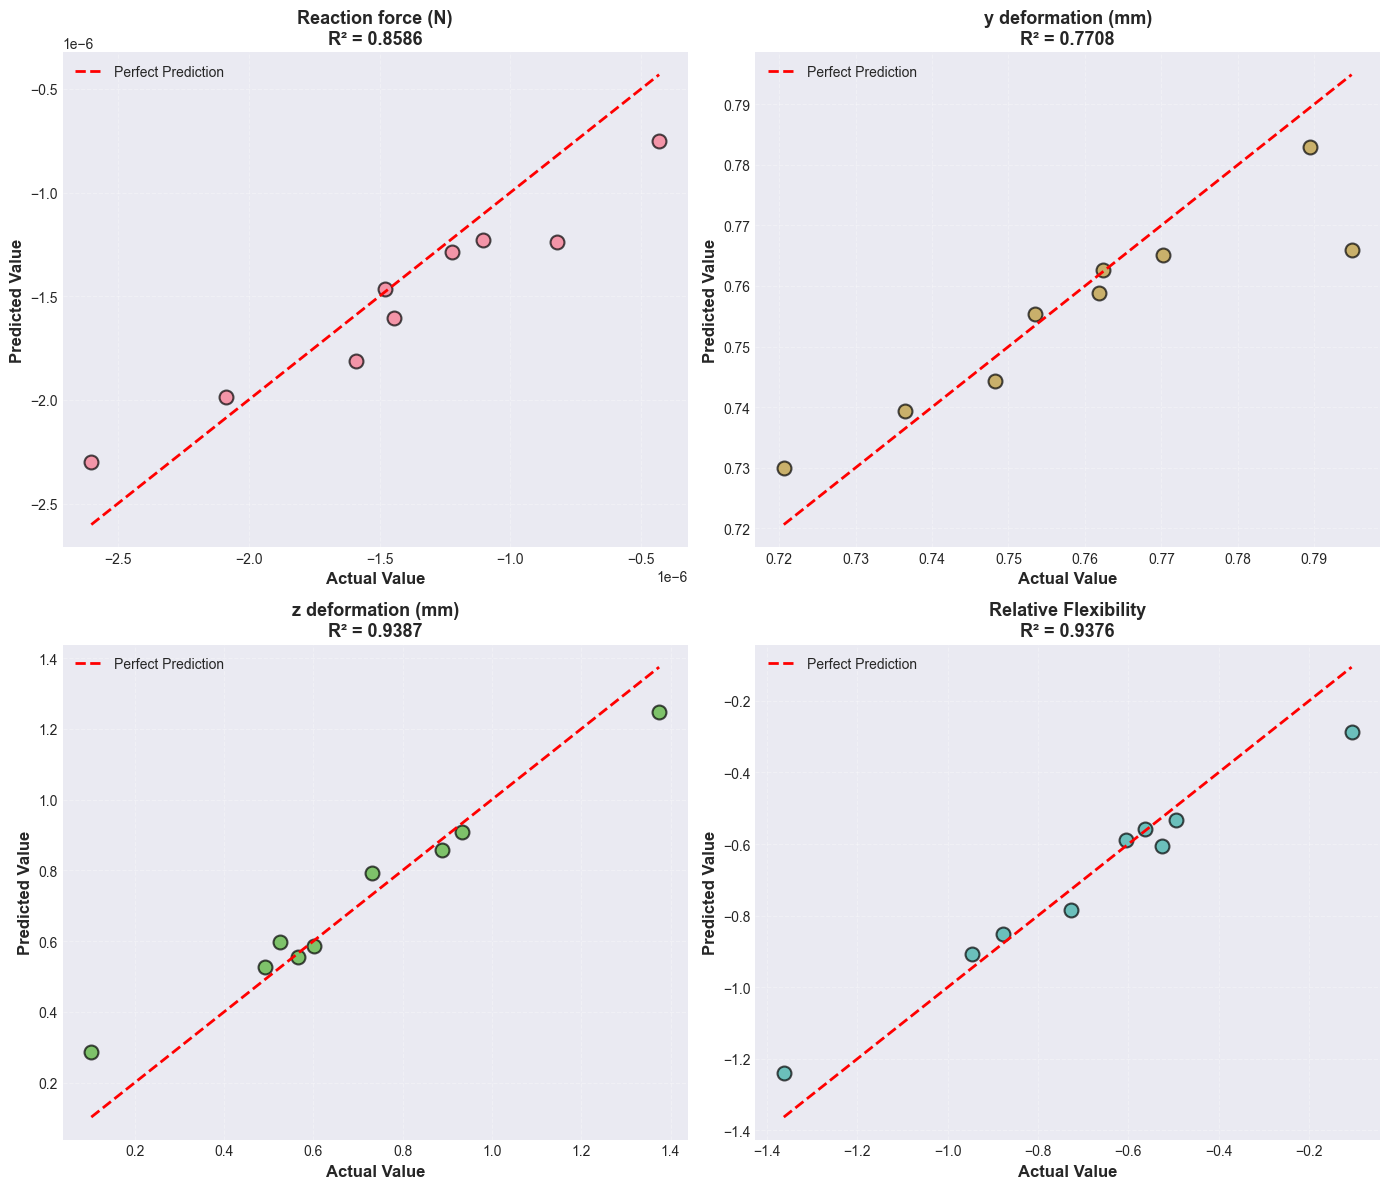

In [7]:
fig = plot_predictions(model, X, y, scaler_X, scaler_y)

Testing 

In [8]:
new_design = {
    'Height': 12.0,
    'Waist_D': 20.0,
    'Top_D': 35.0,
    'Bottom_D': 35.0,
    'Wire': 0.3,
    'CellD_V': 8,
    'CellD_H': 32,
    'Height_adj': 12.6,
    'V_planespace': 1.575,
    'Angle_adjustment': 0.43,
    'Mesh Element Size': 1.0,
    'Displacement': -1.0
}

predictions = predict_new_design(model, scaler_X, scaler_y, new_design)

INPUT PARAMETERS:
  Height                    = 12.0000
  Waist_D                   = 20.0000
  Top_D                     = 35.0000
  Bottom_D                  = 35.0000
  Wire                      = 0.3000
  CellD_V                   = 8.0000
  CellD_H                   = 32.0000
  Height_adj                = 12.6000
  V_planespace              = 1.5750
  Angle_adjustment          = 0.4300
  Mesh Element Size         = 1.0000
  Displacement              = -1.0000

PREDICTED OUTPUTS:
  Reaction force (N)             = -1.986808e-06
  y deformation (mm)             = 0.758763
  z deformation (mm)             = 0.856288
  Relative Flexibility           = -0.852010

DESIGN EVALUATION:
  Reaction Force: -1.986808e-06
    Moderate - Could be improved

  Y Deformation: 0.7588 mm
    Excellent - Moderate deformation range

  Z Deformation: 0.8563 mm
    Good - Moderate deformation range


In [9]:
def quick_predict(**kwargs):
    """
    Quick prediction function with default values.
    Only specify parameters you want to change.

    Example:
        quick_predict(Wire=0.5, CellD_V=10)
    """
    # Default values based on your data
    defaults = {
        'Height': 12.0,
        'Waist_D': 20.0,
        'Top_D': 35.0,
        'Bottom_D': 35.0,
        'Wire': 0.3,
        'CellD_V': 8,
        'CellD_H': 32,
        'Height_adj': 12.6,
        'V_planespace': 1.575,
        'Angle_adjustment': 0.43,
        'Mesh Element Size': 1.0,
        'Displacement': -1.0
    }

    # Update with provided values
    defaults.update(kwargs)

    return predict_new_design(model, scaler_X, scaler_y, defaults)

print("\nUsage examples:")
print("  quick_predict(Wire=0.5)")
print("  quick_predict(CellD_V=10, CellD_H=40)")
print("  quick_predict(Wire=0.4, Height=13)")



Usage examples:
  quick_predict(Wire=0.5)
  quick_predict(CellD_V=10, CellD_H=40)
  quick_predict(Wire=0.4, Height=13)


In [10]:
# Example 1: Increase wire thickness
print("\n" + "="*70)
print("DESIGN 1: Increased Wire Thickness")
print("="*70)
pred1 = quick_predict(Wire=0.5)

# Example 2: More cells
print("\n" + "="*70)
print("DESIGN 2: Increased Cell Count")
print("="*70)
pred2 = quick_predict(CellD_V=10, CellD_H=40)

# Example 3: Different geometry
print("\n" + "="*70)
print("DESIGN 3: Adjusted Geometry")
print("="*70)
pred3 = quick_predict(Height=13, V_planespace=2.0)


DESIGN 1: Increased Wire Thickness
INPUT PARAMETERS:
  Height                    = 12.0000
  Waist_D                   = 20.0000
  Top_D                     = 35.0000
  Bottom_D                  = 35.0000
  Wire                      = 0.5000
  CellD_V                   = 8.0000
  CellD_H                   = 32.0000
  Height_adj                = 12.6000
  V_planespace              = 1.5750
  Angle_adjustment          = 0.4300
  Mesh Element Size         = 1.0000
  Displacement              = -1.0000

PREDICTED OUTPUTS:
  Reaction force (N)             = -1.986808e-06
  y deformation (mm)             = 0.758763
  z deformation (mm)             = 0.856288
  Relative Flexibility           = -0.852010

DESIGN EVALUATION:
  Reaction Force: -1.986808e-06
    Moderate - Could be improved

  Y Deformation: 0.7588 mm
    Excellent - Moderate deformation range

  Z Deformation: 0.8563 mm
    Good - Moderate deformation range

DESIGN 2: Increased Cell Count
INPUT PARAMETERS:
  Height             